In [1]:
!nvidia-smi

Mon Mar 25 02:55:36 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import math
import numpy as np
import time
import random
from numba import prange, cuda
from numba.cuda.random import (create_xoroshiro128p_states,xoroshiro128p_uniform_float32)

import numba as nb
from numba.types import int32
from pylab import imshow, show

# Matrix Multiplication

In [3]:
# matrix multiplication function
def multiply(matrix1, matrix2, res):
    for i in range(matrix1.shape[0]):
        for j in range(matrix2.shape[1]):
            for k in range(matrix1.shape[0]):
                res[i][j] += matrix1[i][k] * matrix2[k][j]

# input two matrices of size n x m
size = 1000

# Generate random numbers
matrix1 = np.random.randint(100, size=(size, size))
matrix2 = np.random.randint(100, size=(size, size))
res = np.random.randint(1, size=(size, size))

# time the function
start = time.time_ns()
multiply(matrix1, matrix2, res)
end = time.time_ns()

time_diff = end-start
time_diff_s = time_diff / (10 ** 9) # convert to floating-point seconds
print("Time taken for CPU {0:.6f} seconds".format(time_diff_s))

Time taken for CPU 864.639647 seconds


In [4]:
@cuda.jit
def random_2d(arr, rng_states):
    # Per-dimension thread indices and strides
    startx, starty = cuda.grid(2)
    stridex, stridey= cuda.gridsize(2)

    # Linearized thread index
    tid = (stridey * stridex) + (starty * stridex) + startx

    # Use strided loops over the array to assign a random value to each entry
    for j in prange(starty, arr.shape[0], stridey):
        for k in prange(startx, arr.shape[1], stridex):
            arr[j, k] = xoroshiro128p_uniform_float32(rng_states, tid)


@cuda.jit
def multiply(A, B, C):
    """Perform square matrix multiplication of C = A * B """
    # Needs to be 2 per docs: https://numba.pydata.org/numba-doc/latest/cuda/kernels.html#absolute-positions
    i, k = cuda.grid(2)
    if k < A.shape[0] and i < C.shape[0]:
        tmp = A[i, k]
        for j in prange(C.shape[1]):
             C[i, j] += tmp * B[k, j]

# size of matrix
size = 1000

# Array dimensions
X, Y= size, size

# Block and grid dimensions
bx, by = 8, 8
gx, gy = 16, 16

# Total number of threads
nthreads = bx * by * gx * gy

# Initialize a state for each thread
rng_states = create_xoroshiro128p_states(nthreads, seed=1)

# Generate random numbers
matrix1 = cuda.device_array((X, Y), dtype=np.float16)
random_2d[(gx, gy), (bx, by)](matrix1, rng_states)
matrix2 = cuda.device_array((X, Y), dtype=np.float16)
random_2d[(gx, gy), (bx, by)](matrix2, rng_states)
res = cuda.device_array((X, Y), dtype=np.float16)


#https://oneflow2020.medium.com/how-to-choose-the-grid-size-and-block-size-for-a-cuda-kernel-d1ff1f0a7f92
threadsperblock = (32,32)
blockspergrid_x = math.ceil(matrix1.shape[0] / threadsperblock[0])
blockspergrid_y = math.ceil(matrix1.shape[1] / threadsperblock[1])
blockspergrid = (blockspergrid_x, blockspergrid_y)
threadsperblock = 32
blockspergrid = (matrix1.size + (threadsperblock - 1)) // threadsperblock

# timing the function
start = time.time_ns()
multiply[blockspergrid, threadsperblock](matrix1, matrix2, res)
end = time.time_ns()

time_diff = end-start
time_diff_s = time_diff / (10 ** 9) # convert to floating-point seconds
print("Time taken for GPU {0:.6f} seconds".format(time_diff_s))


Time taken for GPU 0.136158 seconds


#Reduction

In [5]:
## reduction
# https://numba.readthedocs.io/en/stable/cuda/examples.html
def reduce(array):
    value = 0
    for element in array:
        value += element
    return value

# input two matrices of size n x m
size = 100000000

# Generate random numbers
array1 = np.random.randint(100, size=(size))

# Timing the function
start = time.time_ns()
reduce(array1)
end = time.time_ns()

time_diff = end-start
time_diff_s = time_diff / (10 ** 9) # convert to floating-point seconds
print("Time taken for CPU {0:.6f} seconds".format(time_diff_s))

Time taken for CPU 10.188811 seconds


In [6]:
# function to generate random 1d array
@cuda.jit
def random_1d(array, rng_states):
    idx = cuda.grid(1)
    if idx < array.size:
        array[idx] = int(xoroshiro128p_uniform_float32(rng_states, idx) * 100)

# https://towardsdatascience.com/cuda-by-numba-examples-215c0d285088
@cuda.jit
def reduce(data):
    tid = cuda.threadIdx.x
    size = len(data)
    if tid < size:
        i = cuda.grid(1)

        # Declare an array in shared memory
        shr = cuda.shared.array(128, int32)  # Reduce shared memory size
        # mod to use only partial memory
        shr[tid % 128] = data[i]

        # Ensure writes to shared memory are visible to all threads before reducing
        cuda.syncthreads()

        s = 1
        while s < cuda.blockDim.x:
            if tid % (2 * s) == 0:
                # stride and add
                shr[tid % 128] += shr[(tid + s) % 128]
            s *= 2
            cuda.syncthreads()

        # After the loop, the zeroth element contains the sum
        if tid == 0:
            data[tid] = shr[0]


# input two matrices of size n x m
size = 100000000

# Array dimensions
X = size

# Initialize a state for each thread
rng_states = create_xoroshiro128p_states(X, seed=1)

# Generate random numbers
array1 = cuda.device_array(size, dtype=np.int32)
#https://oneflow2020.medium.com/how-to-choose-the-grid-size-and-block-size-for-a-cuda-kernel-d1ff1f0a7f92
threadsperblock = 128
blockspergrid = (size + threadsperblock - 1) // threadsperblock
random_1d[blockspergrid, threadsperblock](array1, rng_states)

# Timing the function
start = time.time_ns()
reduce[blockspergrid, threadsperblock](array1)
end = time.time_ns()

time_diff = end-start
time_diff_s = time_diff / (10 ** 9) # convert to floating-point seconds
print("Time taken for GPU {0:.6f} seconds".format(time_diff_s))

Time taken for GPU 0.163223 seconds


# Mandelbrot

Time taken for GPU 5.418967 seconds


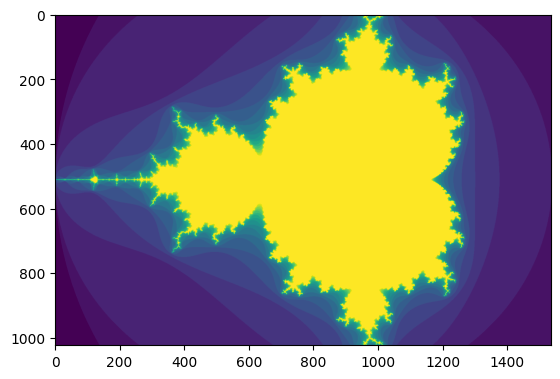

In [7]:
# determines if a complex number is in the Mandelbrot set
def mandel(x, y, max_iters):
  """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
  """
  c = complex(x, y)
  z = 0.0j
  # loop till max_iters
  for i in range(max_iters):
    z = z*z + c
    if (z.real*z.real + z.imag*z.imag) >= 4:
      # return the number of iterations performed
      return i
  # return max iteraters
  return max_iters

# function to create the fractal
def create_fractal(min_x, max_x, min_y, max_y, image, iters):
  height = image.shape[0]
  width = image.shape[1]

  # Calculate pixel size for both axes
  pixel_size_x = (max_x - min_x) / width
  pixel_size_y = (max_y - min_y) / height

  # Iterate over each pixel in the image
  for x in range(width):
    real = min_x + x * pixel_size_x
    for y in range(height):
      imag = min_y + y * pixel_size_y
      # Calculate Mandelbrot set color for the pixel
      color = mandel(real, imag, iters)
      image[y, x] = color

# Generate a image consisting of all zeros
image = np.zeros((1024, 1536), dtype = np.uint8)

# Timing the function
start = time.time_ns()
create_fractal(-2.0, 1.0, -1.0, 1.0, image, 20)
end = time.time_ns()

time_diff = end-start
time_diff_s = time_diff / (10 ** 9) # convert to floating-point seconds
print("Time taken for GPU {0:.6f} seconds".format(time_diff_s))

# Display the generated image
imshow(image)
show()

Time taken for GPU 0.227662 seconds


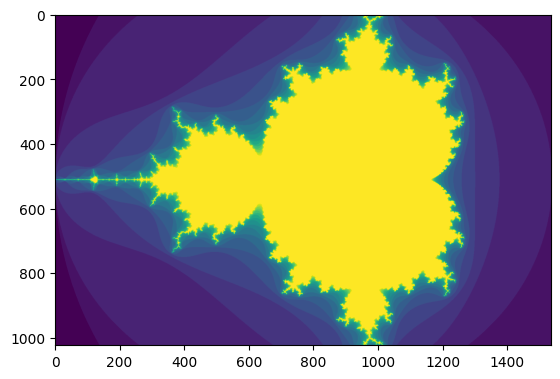

In [8]:
# determines if a complex number is in the Mandelbrot set
@cuda.jit
def mandel(x, y, max_iters):
  """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
  """
  c = complex(x, y)
  z = 0.0j
  # loop till max_iters
  for i in range(max_iters):
    z = z*z + c
    if (z.real*z.real + z.imag*z.imag) >= 4:
      # return the number of iterations performed
      return i
  # return max iteraters
  return max_iters

@cuda.jit
def create_fractal(min_x, max_x, min_y, max_y, image, iters):
  height = image.shape[0]
  width = image.shape[1]

  # Calculate pixel size for both axes
  pixel_size_x = (max_x - min_x) / width
  pixel_size_y = (max_y - min_y) / height

  # Per-dimension thread indices and strides
  startX, startY = cuda.grid(2)
  gridX = cuda.gridDim.x * cuda.blockDim.x
  gridY = cuda.gridDim.y * cuda.blockDim.y

  # Iterate over each pixel in the image
  for x in range(startX, width, gridX):
    real = min_x + x * pixel_size_x
    for y in range(startY, height, gridY):
      imag = min_y + y * pixel_size_y
      # Calculate Mandelbrot set color for the pixel
      image[y, x] = mandel(real, imag, iters)

#  generate a image of zeros
gimage = np.zeros((1024, 1536), dtype = np.uint8)
blockdim = (32, 8)
griddim = (32,16)

# generate the output image matrix
d_image = cuda.to_device(gimage)

# Timing the function
start = time.time_ns()
create_fractal[griddim, blockdim](-2.0, 1.0, -1.0, 1.0, d_image, 20)
end = time.time_ns()

time_diff = end-start
time_diff_s = time_diff / (10 ** 9) # convert to floating-point seconds
print("Time taken for GPU {0:.6f} seconds".format(time_diff_s))

# Display the generated image
imshow(d_image)
show()